<a href="https://colab.research.google.com/github/srujanay18/linear_models_assignment/blob/main/FINAL_A6_linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1
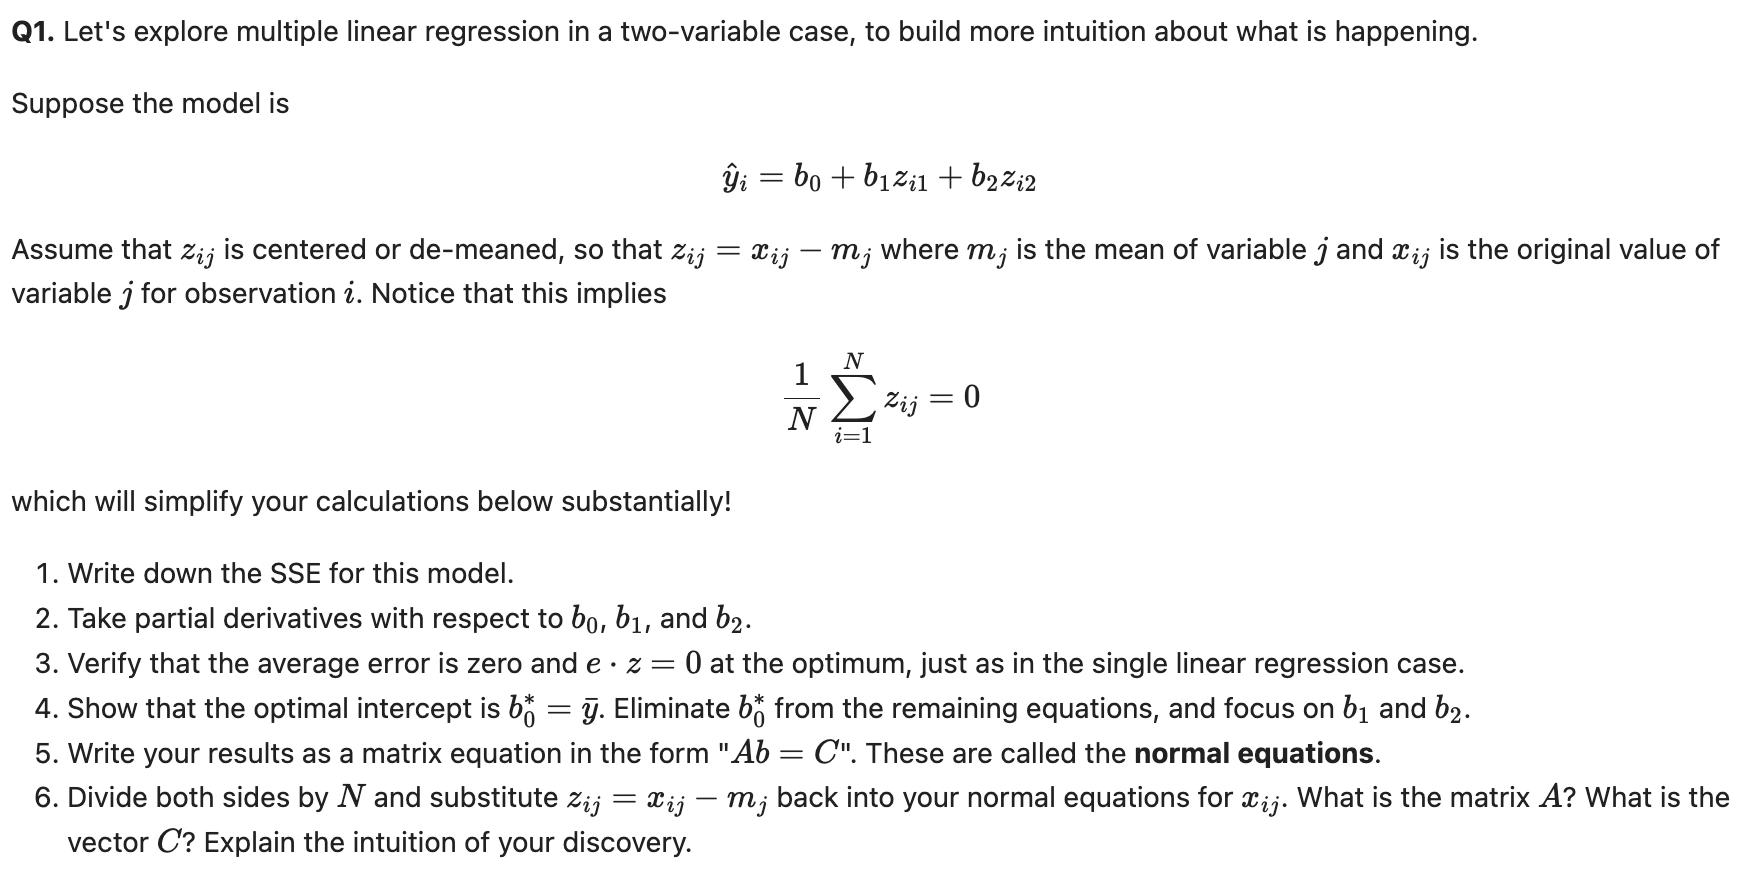

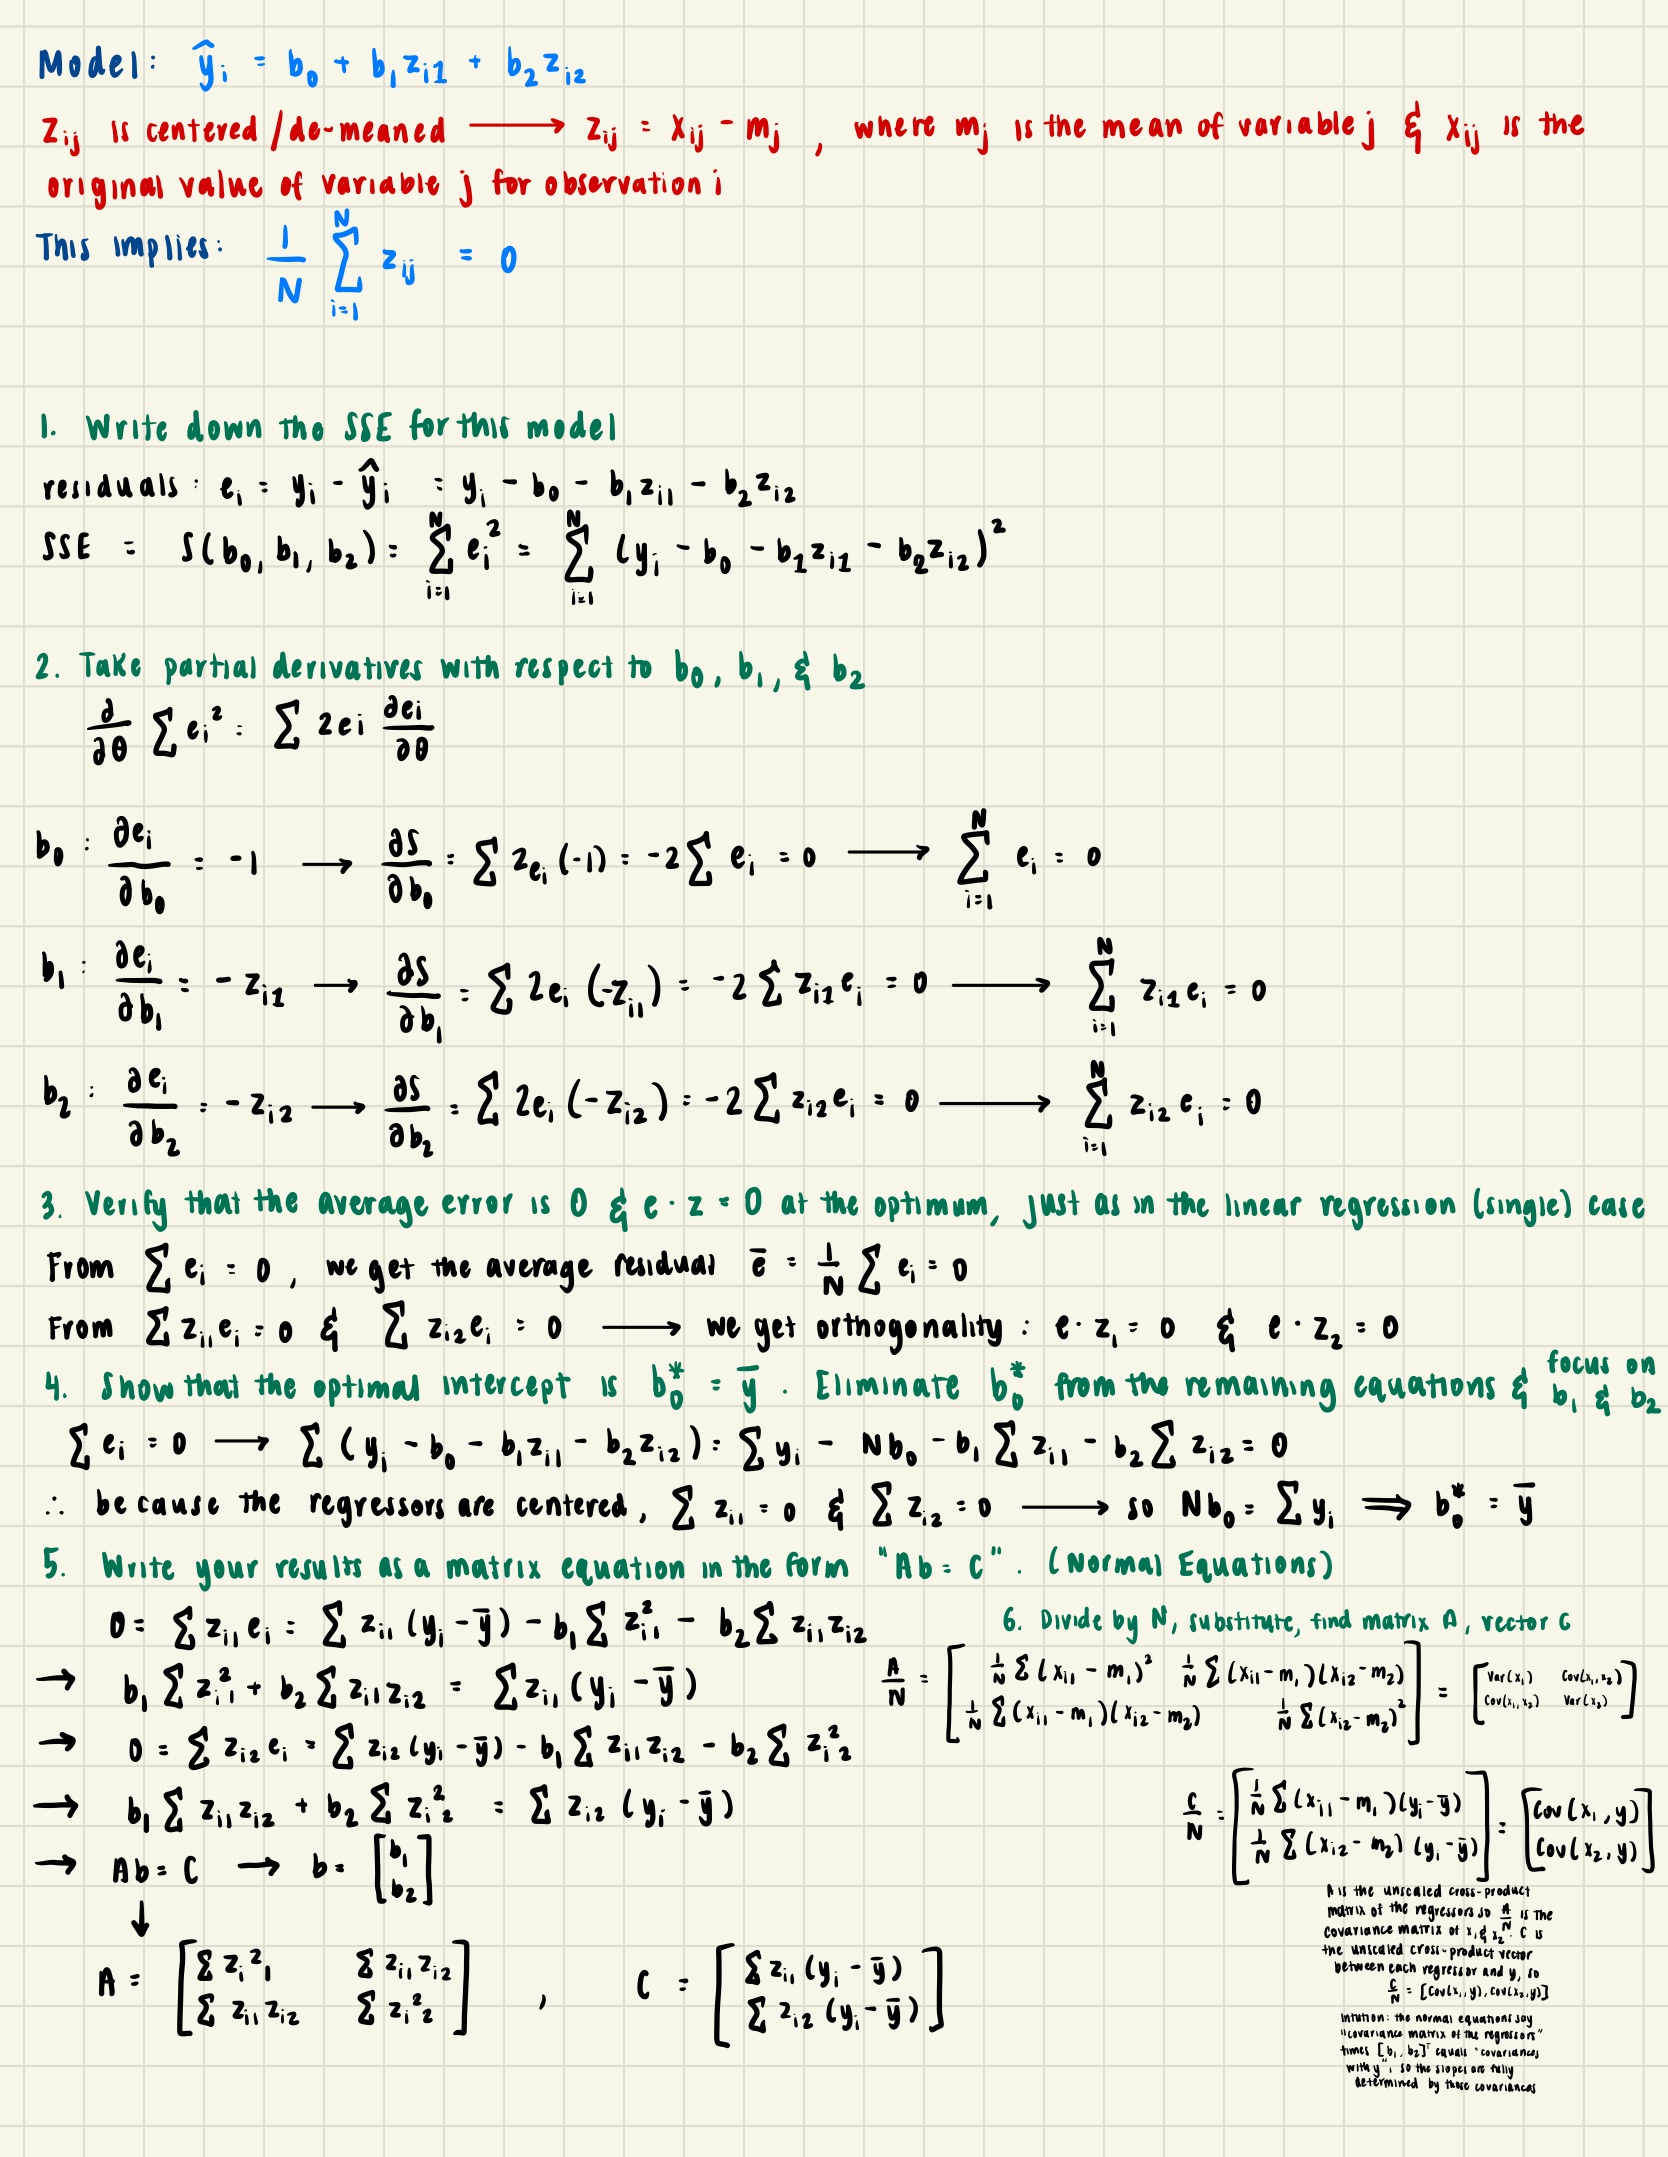

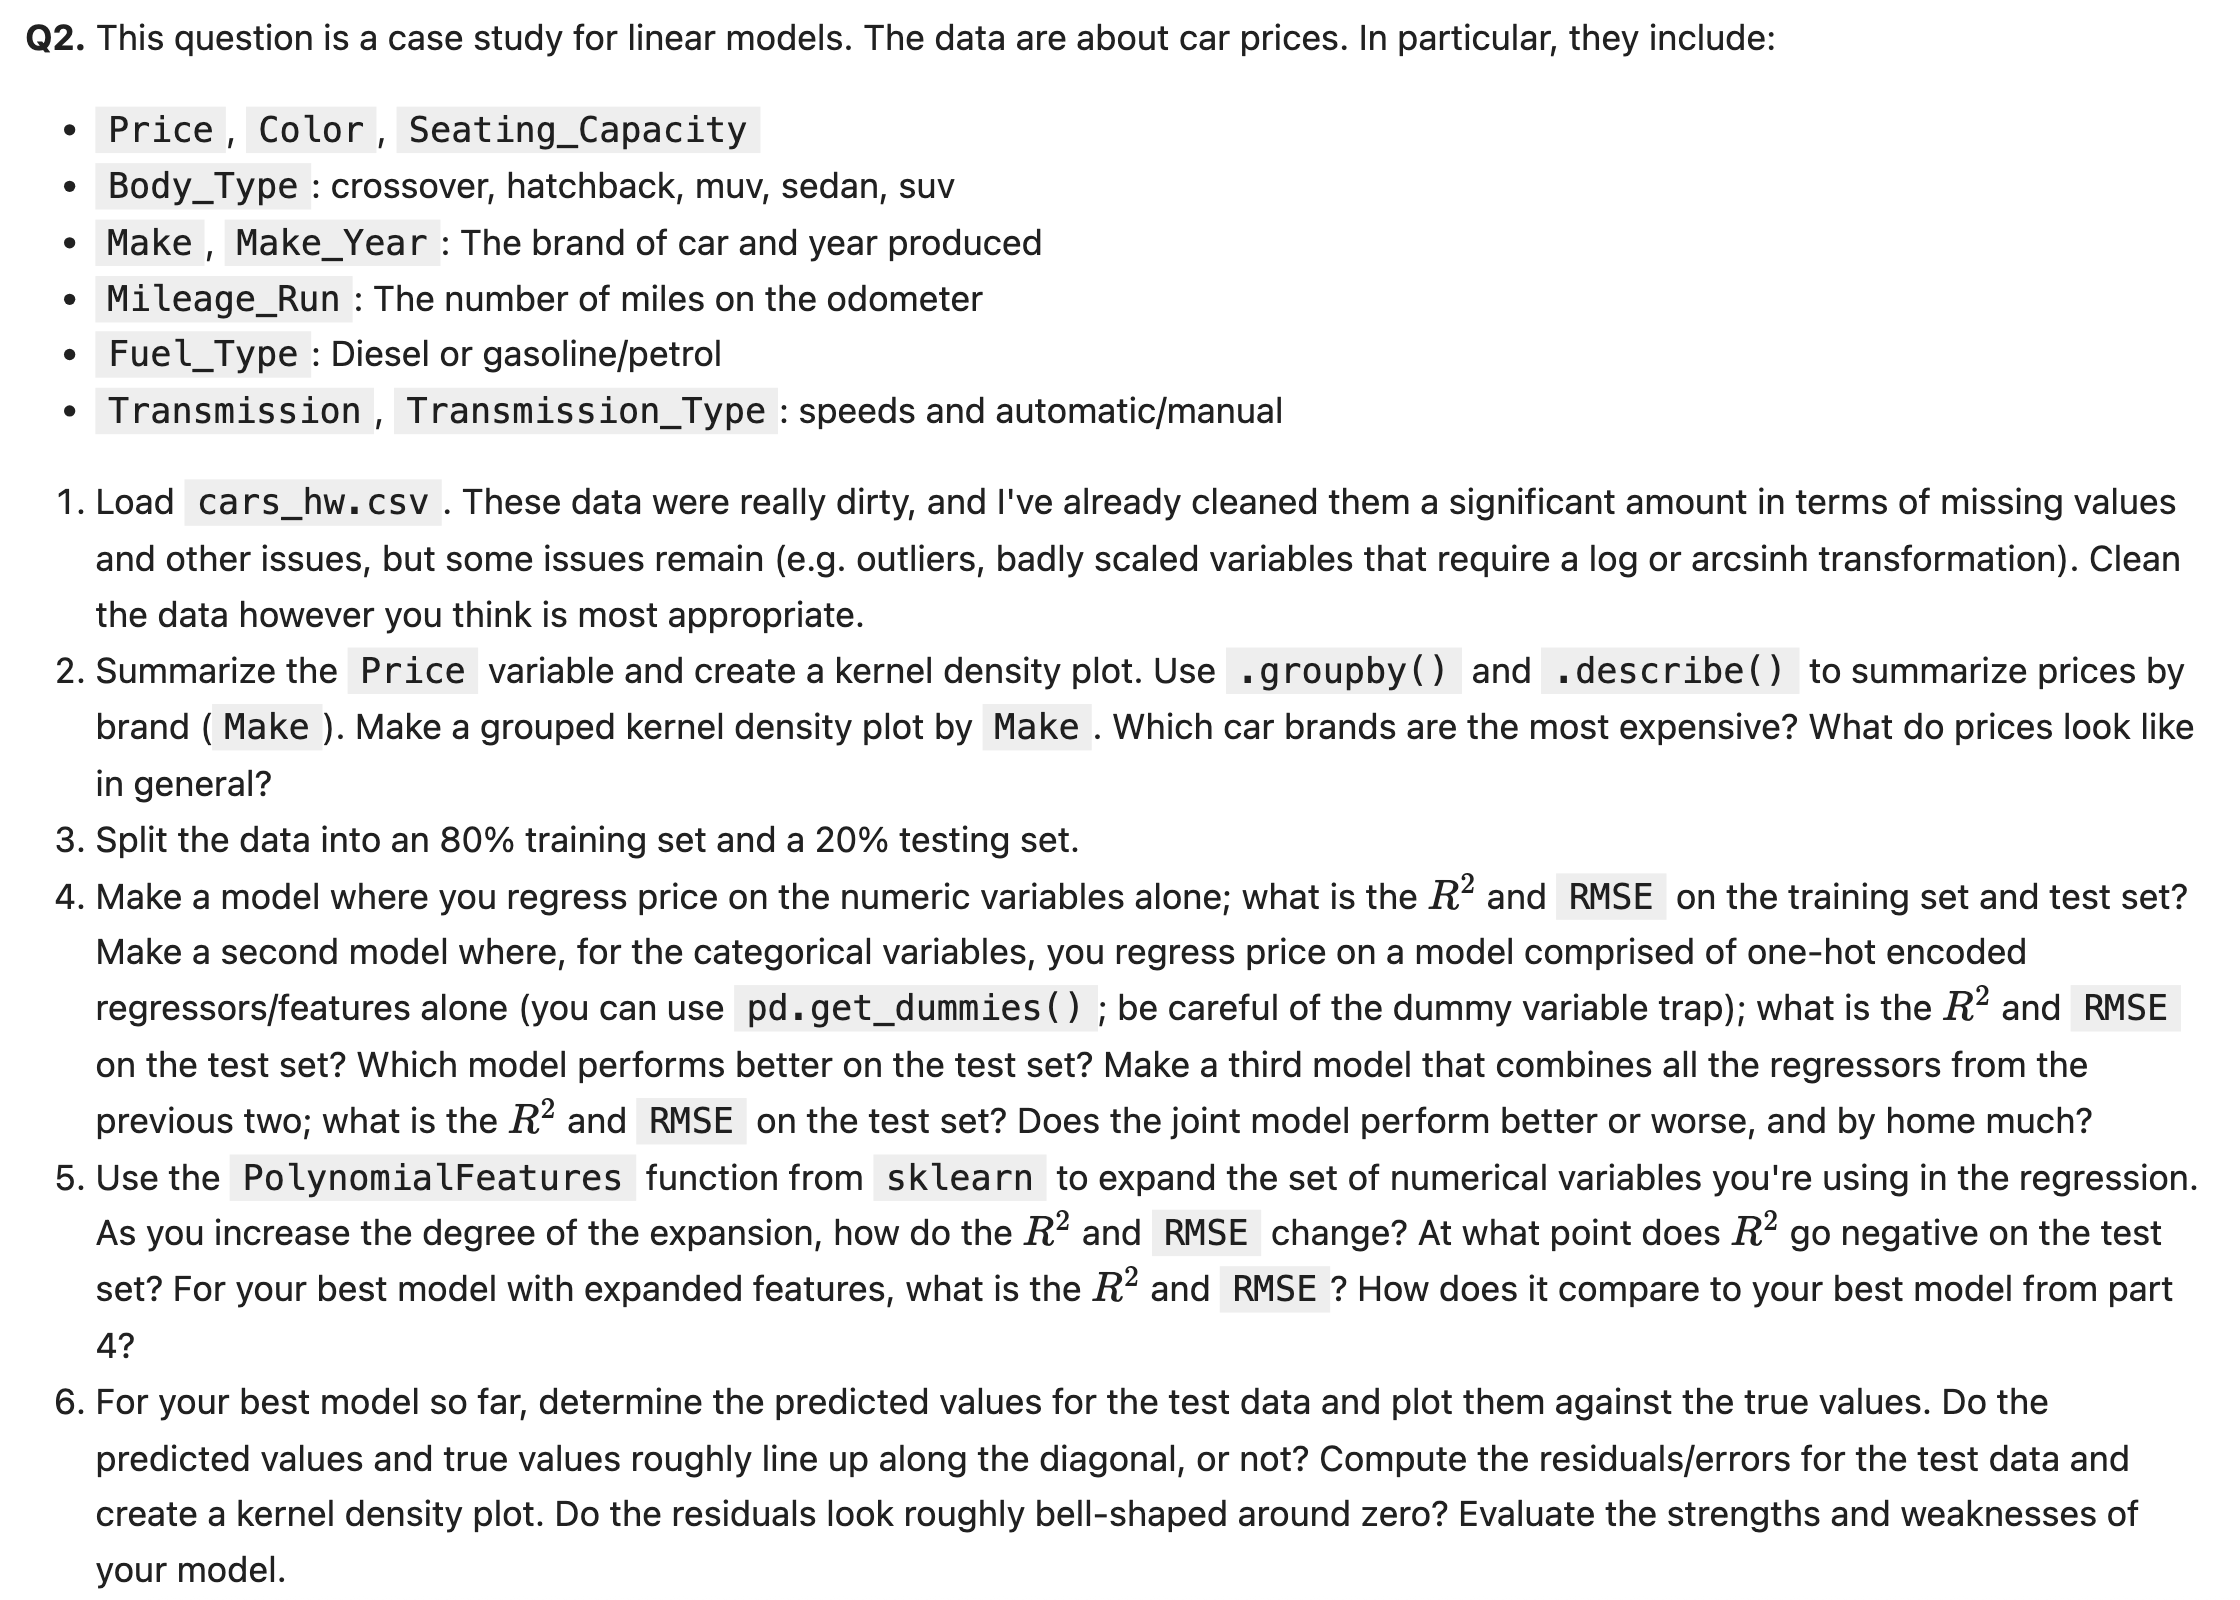

In [1]:
# Load cars_hw.csv. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues,
# but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.

import pandas as pd, numpy as np

df = pd.read_csv("/content/cars_hw.csv")
df.columns = [c.strip() for c in df.columns]

# kept columns
keep = ['Price','Color','Seating_Capacity','Body_Type','Make','Make_Year',
        'Mileage_Run','Fuel_Type','Transmission','Transmission_Type']
df = df[[c for c in keep if c in df.columns]].copy()

# coerce
for c in ['Price','Seating_Capacity','Make_Year','Mileage_Run']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# drop missing values in the fields
df = df.dropna(subset=[c for c in ['Price','Make_Year','Mileage_Run','Seating_Capacity'] if c in df.columns])

# trim the extreme outliers
for c in ['Price','Mileage_Run','Make_Year','Seating_Capacity']:
    if c in df.columns:
        lo, hi = df[c].quantile([0.01, 0.99])
        df = df[(df[c] >= lo) & (df[c] <= hi)]

# fix the skew on mileage
df['logMileage'] = np.log1p(df['Mileage_Run'])
df.shape

(925, 11)

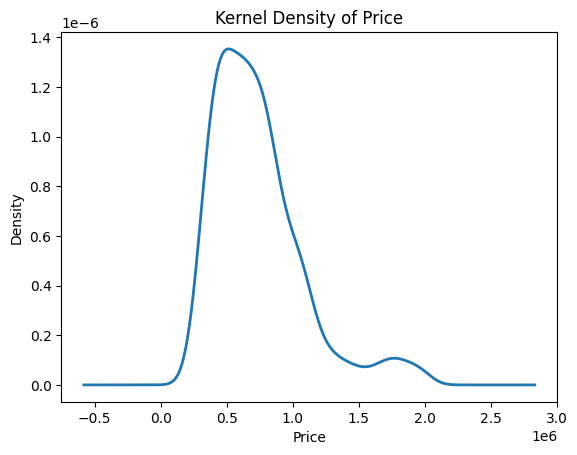

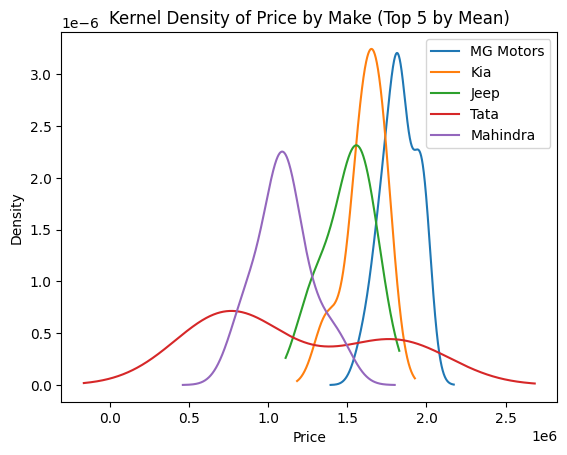

(count    9.250000e+02
 mean     7.338595e+05
 std      3.421561e+05
 min      2.710000e+05
 25%      4.820000e+05
 50%      6.640000e+05
 75%      8.810000e+05
 max      1.978000e+06
 Name: Price, dtype: float64,
                    mean        50%
 Make                              
 MG Motors  1.830333e+06  1822000.0
 Kia        1.614750e+06  1628500.0
 Jeep       1.499500e+06  1529500.0
 Tata       1.154133e+06   869000.0
 Mahindra   1.100167e+06  1094500.0)

In [2]:
# Summarize the Price variable and create a kernel density plot. Use .groupby() and .describe() to summarize prices by brand (Make).
# Make a grouped kernel density plot by Make. Which car brands are the most expensive? What do prices look like in general?

import matplotlib.pyplot as plt

price_desc = df['Price'].describe()
by_make = df.groupby('Make')['Price'].describe().sort_values('mean', ascending=False)

# overall KDE
plt.figure()
df['Price'].plot(kind='kde', linewidth=2)
plt.title('Kernel Density of Price'); plt.xlabel('Price'); plt.ylabel('Density')
plt.show()

# KDE by Make for top 5 mean prices
top5_makes = by_make.head(5).index.tolist()
plt.figure()
for mk in top5_makes:
    df.loc[df['Make']==mk, 'Price'].plot(kind='kde', linewidth=1.5, label=mk)
plt.title('Kernel Density of Price by Make (Top 5 by Mean)'); plt.xlabel('Price'); plt.ylabel('Density'); plt.legend()
plt.show()

price_desc, by_make.head(5)[['mean','50%']]

The most expensive brands by mean price are MG Motors and Kia. In general, prices are right-skewed with a mass in the mid range and a thinner high-price tail.

In [6]:
# Split the data into an 80% training set and a 20% testing set.

from sklearn.model_selection import train_test_split

y = df['Price']
num_features = [c for c in ['Make_Year','Seating_Capacity','logMileage'] if c in df.columns]
X_num = df[num_features].copy()

X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape

((740, 3), (185, 3))

In [10]:
# Make a model where you regress price on the numeric variables alone; what is the R^2 and RMSE on the training set and test set?
# Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use pd.get_dummies();
# be careful of the dummy variable trap); what is the R^2 and RMSE on the test set? Which model performs better on the test set?
# Make a third model that combines all the regressors from the previous two; what is the R^2 and RMSE on the test set? Does the joint model perform better or worse, and by home much?

# numeric-only linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
rmse = lambda yt, yp: np.sqrt(mean_squared_error(yt, yp))

m_num = LinearRegression().fit(X_train, y_train)
pred_tr_a = m_num.predict(X_train); pred_te_a = m_num.predict(X_test)

metrics_a = {
    "train_R2": r2_score(y_train, pred_tr_a),
    "train_RMSE": rmse(y_train, pred_tr_a),
    "test_R2": r2_score(y_test, pred_te_a),
    "test_RMSE": rmse(y_test, pred_te_a)
}

# categorical-only (one-hot)
cat_cols = [c for c in ['Color','Body_Type','Make','Fuel_Type','Transmission','Transmission_Type'] if c in df.columns]
X_cat = pd.get_dummies(df[cat_cols], drop_first=True)

Xc_train, Xc_test = X_cat.loc[X_train.index], X_cat.loc[X_test.index]
m_cat = LinearRegression().fit(Xc_train, y_train)
pred_tr_b = m_cat.predict(Xc_train); pred_te_b = m_cat.predict(Xc_test)

metrics_b = {
    "train_R2": r2_score(y_train, pred_tr_b),
    "train_RMSE": rmse(y_train, pred_tr_b),
    "test_R2": r2_score(y_test, pred_te_b),
    "test_RMSE": rmse(y_test, pred_te_b)
}

# combined model
X_comb = pd.concat([X_num, X_cat], axis=1)
Xcm_train, Xcm_test = X_comb.loc[X_train.index], X_comb.loc[X_test.index]

m_all = LinearRegression().fit(Xcm_train, y_train)
pred_tr_c = m_all.predict(Xcm_train); pred_te_c = m_all.predict(Xcm_test)

metrics_c = {
    "train_R2": r2_score(y_train, pred_tr_c),
    "train_RMSE": rmse(y_train, pred_tr_c),
    "test_R2": r2_score(y_test, pred_te_c),
    "test_RMSE": rmse(y_test, pred_te_c)
}


print(metrics_a)
print(metrics_b)
print(metrics_c)

{'train_R2': 0.30955772223464595, 'train_RMSE': np.float64(286353.6082388857), 'test_R2': 0.3639961373163543, 'test_RMSE': np.float64(263918.0524297511)}
{'train_R2': 0.7606316588558775, 'train_RMSE': np.float64(168605.72873238917), 'test_R2': 0.7317775615095289, 'test_RMSE': np.float64(171390.51126438254)}
{'train_R2': 0.86021912270203, 'train_RMSE': np.float64(128843.60048289236), 'test_R2': 0.8338595719663686, 'test_RMSE': np.float64(134889.10824904192)}


Numeric-only: Train R² = 0.3096, RMSE = 286,354; Test R² = 0.3640, RMSE = 263,918.

Categorical-only: Train R² = 0.7606, RMSE = 168,606; Test R² = 0.7318, RMSE = 171,391.

Combined: Train R² = 0.8602, RMSE = 128,844; Test R² = 0.8339, RMSE = 134,889.

The combined model performs best on the test set.

In [5]:
# Use the PolynomialFeatures function from sklearn to expand the set of numerical variables you're using in the regression.
# As you increase the degree of the expansion, how do the R^2 and RMSE change? At what point does R^2 go negative on the test set?
# For your best model with expanded features, what is the R^2 and RMSE? How does it compare to your best model from part 4?

from sklearn.preprocessing import PolynomialFeatures

results = []
for d in [1,2,3,4,5]:
    pf = PolynomialFeatures(degree=d, include_bias=False)
    Xn_tr = pf.fit_transform(X_train[num_features])
    Xn_te = pf.transform(X_test[num_features])
    Xtr = np.hstack([Xn_tr, Xc_train.values])
    Xte = np.hstack([Xn_te, Xc_test.values])

    mdl = LinearRegression().fit(Xtr, y_train)
    ytr = mdl.predict(Xtr); yte = mdl.predict(Xte)
    results.append([d, r2_score(y_train,ytr), rmse(y_train,ytr), r2_score(y_test,yte), rmse(y_test,yte)])

pd.DataFrame(results, columns=['degree','train_R2','train_RMSE','test_R2','test_RMSE'])

,degree,train_R2,train_RMSE,test_R2,test_RMSE
0,1,0.860219,128843.600483,8.338596e-01,1.348891e+05
1,2,0.863653,127251.356108,8.207187e-01,1.401221e+05
2,3,0.864491,126859.656984,-2.426428e+01,1.663385e+06
3,4,0.865154,126548.968258,-9.494980e+08,1.019732e+10
4,5,0.353867,277012.778989,-1.019862e+09,1.056842e+10


As degree increases, train R² goes up slightly but test performance goes down.

Degree 1: Test R² = 0.834, RMSE = 134,889

Degree 2: Test R² = 0.821, RMSE = 140,122

Degree 3+: Test R² becomes negative (first at degree 3), with RMSE becoming extremely large.

The best expanded model is degree 1. It matches the best model from Part 4 and higher-degree polynomials seems to hurt generalization.

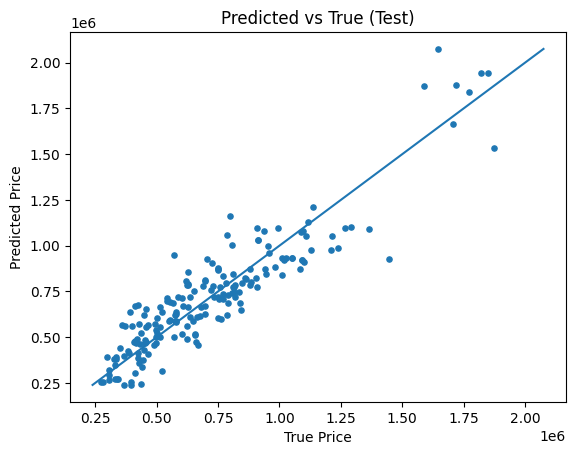

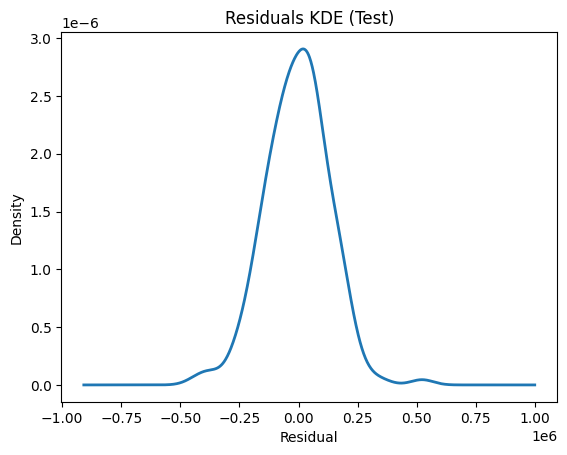

(count       185.000000
 mean      -5360.766715
 std      135148.302908
 min     -431305.590265
 25%      -95859.127841
 50%       -4469.864522
 75%       71665.587536
 max      522032.354849
 Name: Price, dtype: float64,
 np.float64(-5360.766714577579),
 135148.30290808075)

In [7]:
# For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not?
# Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

import matplotlib.pyplot as plt

y_pred = pred_te_c

# predicted vs true
plt.figure()
plt.scatter(y_test, y_pred, s=14)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims)
plt.xlabel('True Price'); plt.ylabel('Predicted Price'); plt.title('Predicted vs True (Test)')
plt.show()

# residual KDE
resid = y_test - y_pred
plt.figure()
pd.Series(resid).plot(kind='kde', linewidth=2)
plt.title('Residuals KDE (Test)'); plt.xlabel('Residual'); plt.ylabel('Density')
plt.show()

resid.describe(), resid.mean(), resid.std(ddof=1)

The predictions line up along the line with some spread at higher prices. The residuals are centered near zero and are bell-shaped but have tails. The strengths are the strong test fit (R² ≈ 0.834) and residual center. The weaknesses are the heavier tails and wider errors for high-price cars which might be due to unmodeled nonlinearity or missing features.